In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

from nltk.corpus import stopwords
import string
import nltk
from nltk import PorterStemmer

from textblob import TextBlob
from wordcloud import WordCloud
from collections import Counter

In [2]:
amazon_food_review = pd.read_csv('./datasets/amazon_reviews.csv')   # (568454, 10)

# Familiar with dataset
The amazon_reviews dataset has 568454 rows and 10 columns. Each row stands for each customer review.

The columns' names are: 'Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'
       
For this project, I want to figure out if the customer gave a positive score, what were the high frequency words they talked about in 'Summary' section. I will only pick columns 'id', 'Score', and 'Summary'.

In [3]:
df = amazon_food_review[['Id', 'Score', 'Summary']]

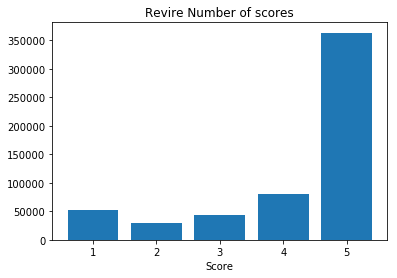

In [23]:
x_value = list(Counter(df['Score']).keys())
y_value = list(Counter(df['Score']).values())

plt.bar(x_value, y_value)
plt.xlabel('Score')
plt.title('Revire Number of scores');

In [4]:
df['Score'] = df['Score'].map(lambda x: 0 if x<3 else 1)

/Users/fmeng90/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [6]:
df.head(2)

,Id,Score,Summary
0,1,1,Good Quality Dog Food
1,2,0,Not as Advertised


In [7]:
df[df.columns[df.isnull().any()]].isnull().sum()

Summary    26
dtype: int64

In [5]:
df.loc[df['Summary'].isnull(), 'Summary'] = 'no_review'

/Users/fmeng90/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [10]:
def cleaner(text):
    stemmer = PorterStemmer()
    stop = stopwords.words('english')
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.translate(str.maketrans('', '', string.digits))
    text = text.lower().strip()
    final_text = []
    for w in text.split():
        if w not in stop:
            final_text.append(stemmer.stem(w.strip()))
    return ' '.join(final_text)

In [ ]:
cv = CountVectorizer(preprocessor=cleaner)

In [4]:
tfidf = TfidfVectorizer(preprocessor=cleaner)

In [11]:
def transform(matrix, cv):
    cv.fit(matrix)
    transformed = pd.DataFrame(cv.transform(matrix).todense(),
                              columns=cv.get_feature_names())
    print('size: ', transformed.shape)
    print('Top 10 words:\n', transformed.sum().sort_values(ascending=False).head(10))
    
    return transformed

In [ ]:
transform(df['Summary'], tfidf)

size:  (568454, 33058)


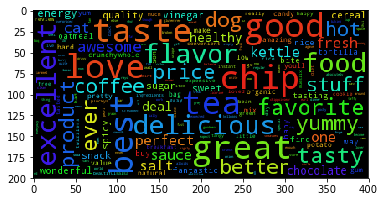

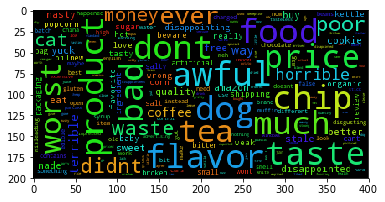

In [16]:
positive_words = ''
negative_words = ''

positive = df.loc[df['Score']==1,:]
positive = positive[:1000]
negative = df.loc[df['Score']==0,:]
negative = negative[:1000]


for val in positive['Summary']:
    text = val.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.translate(str.maketrans('', '', string.digits))
    tokens = nltk.word_tokenize(text)
    tokens = [i for i in tokens if i not in stopwords.words('english')]
    for words in tokens:
        positive_words = positive_words + words + ' '
        
plt.ion()
wordcloud = WordCloud(max_font_size=40).generate(positive_words)
plt.figure()
plt.imshow(wordcloud);


for val in negative['Summary']:
    text = val.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.translate(str.maketrans('', '', string.digits))
    tokens = nltk.word_tokenize(text)
    if 'good' in tokens:
        tokens.remove('good')
    if 'great' in tokens:
        tokens.remove('great')
    for words in tokens:
        negative_words = negative_words + words + ' '
        
wordcloud = WordCloud(max_font_size=40).generate(negative_words)
plt.figure()
plt.imshow(wordcloud);

In [20]:
# Using textblob to do sentiment analysis
# subjectivity(0 to 1): 
#       0 is the most objective in tone, 1 is the most subjective in tone
# polarity(-1 to 1):
#       -1 is the most negative in tone, 1 is the most positive in tone

positive_review = TextBlob(positive_words)
print('positive_review')
print(positive_review.sentiment.subjectivity, positive_review.sentiment.polarity, '\n')

negative_review = TextBlob(negative_words)
print('negative_review')
print(negative_review.sentiment.subjectivity, negative_review.sentiment.polarity, '\n')

positive_review
0.6508728285530802 0.5269262894889859 

negative_review
0.6191237277631585 -0.18927979233826311 



In [11]:
# Use tfidfVectorizer to take out 1500 of the most common features
tfidf = TfidfVectorizer(preprocessor=cleaner,ngram_range=(1,2),max_features=1500)
tfidf.fit(df['Summary'][:10000])
X = tfidf.transform(df['Summary'][:10000])
         ##  X type is scipy csr_matrix

In [12]:
# use TruncatedSVD to reduce the features from 1500 to 500
tsvd = TruncatedSVD(n_components=500)
X = tsvd.fit_transform(X)
      # X.todense() can convert X into a dense matrix

In [14]:
# Use a RandomForestClassifier to create the model
rfc = RandomForestClassifier(n_estimators=100,max_depth=7)
rfc.fit(X, df['Score'][:10000])

print('Training Data: ', cross_val_score(rfc, X, df['Score'][:10000]).mean())

Training Data:  0.858699907183


# LDA

In [7]:
cv = CountVectorizer(stop_words='english')
cv.fit(df['Summary'][:10000])
X = cv.transform(df['Summary'][:10000])
feature_names = cv.get_feature_names()

lda = LatentDirichletAllocation()  # default 10 topics
lda.fit(X)

results = pd.DataFrame(lda.components_,
                      columns=feature_names)

# Print top 25 most frequncy occuring words for each topic
for topic in range(10):
    print('Topic', topic)
    word_list = results.T[topic].sort_values(ascending=False).index
    print(' '.join(word_list[0:25]), '\n')

/Users/fmeng90/anaconda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


Topic 0
product great favorite chocolate yum good dogs okay disappointed new weak decent constipation choice wow packaging crazy tried shipping flavors terrible diet bag outstanding idea 

Topic 1
best tea excellent better mix organic drink tasting real milk ve convenient energy green expected old flavorful bread jerky tasted simply surprisingly crackers pancake soy 

Topic 2
perfect nice wonderful really snack little treats fresh amazon make pancakes fruit dark salty miracle espresso wrong pricey yuck bland plant crunchy batch ordered fabulous 

Topic 3
baby easy wolfgang cats puck formula vanilla makes coconut hard work time gum food pop mild soup special variety super order pack beware corn goodness 

Topic 4
awesome cocoa ok sugar way water juice roast eat happy seeds fun bed french medium senseo powder day try cake pods sticks non favorites chia 

Topic 5
yummy hot good just quality bad tastes breakfast use expensive healthy high spicy white horrible quick ll fast brand texture af

In [9]:
# For each topic, which Summary is most likely to belong to that topic
topic_names = ['topic %s' % topic for topic in range(10)]

results = pd.DataFrame(lda.transform(X),
                      columns=topic_names)
joined = df[['Id','Summary']].join(results)
for topic in topic_names:
    print(topic)
    print(joined.sort_values(by=topic, ascending=False)[['Summary', topic]].head(1).values)
    print('\n')

topic 0
[['Recieved the Holiday Sampler with a Couple Summer Teas'
  0.871427661205735]]


topic 1
[["Marley's Mellow Mood Lite - Half Tea Half Lemonade" 0.8999999989043345]]


topic 2
[['Ketchup powdery coating excessive, overdone gritty' 0.8714285701631012]]


topic 3
[['CHANGED FORMULA MAKES CATS SICK!!!!' 0.8499999999031912]]


topic 4
[['Detailed reply from company over infant feeding and DHA/ARA'
  0.8874999985894086]]


topic 5
[["Woeber's Sandwich Pal Hot & Spicy Mustard" 0.8714279098113531]]


topic 6
[['Afforable Low-Noise XLR-To-USB Preamp' 0.8714285706218127]]


topic 7
[['Equidorian OJio Arriba Carillo "RAW Oranic" Cacao' 0.8874999979661283]]


topic 8
[['Es muy buena para bebes con problemas de alergias alimenticias'
  0.8999999989884164]]


topic 9
[['great dog food for my min pin 14 lb. dog!!!' 0.8999996031948205]]


